# MultiModal RAG App for Video Processing With LlamaIndex and LanceDB

In [1]:
# === Core LlamaIndex ===
!pip install llama_index                     # Core LlamaIndex framework

# === Vector Stores ===
!pip install lancedb                         # LanceDB backend
!pip install llama-index-vector-stores-lancedb  # LlamaIndex wrapper for LanceDB

# === Embeddings ===
!pip install sentence-transformers           # Hugging Face sentence embeddings (E5, BGE, etc.)
!pip install llama-index-embeddings-huggingface  # LlamaIndex integration for Hugging Face embeddings
!pip install llama-index-embeddings-clip   # LlamaIndex wrapper for using OpenAI CLIP embeddings inside LlamaIndex pipelines
!pip install git+https://github.com/openai/CLIP.git   # Official OpenAI CLIP implementation (required backend for ClipEmbedding)

# === Readers / Input Data ===
!pip install llama-index-readers-file        # File reader for transcripts/text/metadata
!pip install yt_dlp                          # YouTube downloader (fetch video/audio)
!pip install -U openai-whisper                       # OpenAI Whisper (speech-to-text)
!pip install moviepy                         # Video/audio processing

# === LLMs (Google Gemini) ===
!pip install llama-index-llms-google-genai   # Gemini wrapper for LlamaIndex

# === Torch Backend ===
!pip install torch torchvision               # Required for embeddings, Whisper, moviepy, etc.

INFO: pip is looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 56.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6n8i0y_y
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6n8i0y_y
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 482.6 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369549 sha256=1252acda19494c8c88d958a29c7f3798b7d7fe759aea83fb941c91fc577cb26b
  Stored in directory: /tmp/pip-ephem-wheel-cache-hsah6hfu/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB

In [2]:
from pathlib import Path
import os
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [3]:
print(os.getcwd())

/content


In [4]:
os.listdir('drive/MyDrive/Colab Notebooks')

['MultiModal_RAG_with_llamaIndex_and_LanceDB.ipynb',
 '.ipynb_checkpoints',
 'RAG_Langchain_gemini_API_and_FAISS.ipynb',
 'RAG_Langchain_mistral_qdrant.ipynb']

In [5]:
output_video_path = "/content/video_data/"
output_folder = "/content/mixed_data/"
output_audio_path = "/content/mixed_data/output_audio.wav"
input_video_path = "/content/video_data/input_vid.mp4"

In [6]:
!mkdir mixed_data

In [7]:
from yt_dlp import YoutubeDL

def download_video(url, output_dir):
    ydl_opts = {
        "format": "bestvideo+bestaudio/best",
        "merge_output_format": "mp4",
        "outtmpl": f"{output_dir}/input_vid.%(ext)s",  # fixed filename
    }

    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)

    metadata = {
        "Author": info.get("uploader"),
        "Title": info.get("title"),
        "Views": info.get("view_count"),
    }
    return metadata

In [8]:
video_url="https://youtu.be/3dhcmeOTZ_Q"

In [9]:
metadata_vid = download_video(video_url, output_video_path)

[youtube] Extracting URL: https://youtu.be/3dhcmeOTZ_Q
[youtube] 3dhcmeOTZ_Q: Downloading webpage
[youtube] 3dhcmeOTZ_Q: Downloading tv simply player API JSON
[youtube] 3dhcmeOTZ_Q: Downloading tv client config
[youtube] 3dhcmeOTZ_Q: Downloading player 6742b2b9-main
[youtube] 3dhcmeOTZ_Q: Downloading tv player API JSON
[info] 3dhcmeOTZ_Q: Downloading 1 format(s): 303+251
[download] Destination: /content/video_data//input_vid.f303.webm
[download] 100% of    7.49MiB in 00:00:00 at 19.01MiB/s  
[download] Destination: /content/video_data//input_vid.f251.webm
[download] 100% of    4.02MiB in 00:00:00 at 6.76MiB/s   
[Merger] Merging formats into "/content/video_data//input_vid.mp4"
Deleting original file /content/video_data//input_vid.f303.webm (pass -k to keep)
Deleting original file /content/video_data//input_vid.f251.webm (pass -k to keep)


In [10]:
metadata_vid

{'Author': '3-Minute Data Science',
 'Title': 'Linear Regression in 3 Minutes',
 'Views': 57881}

In [11]:
from moviepy.editor import VideoFileClip

def video_to_images(video_path,output_folder):
  clip=VideoFileClip(video_path)
  clip.write_images_sequence(
      os.path.join(output_folder,"frame%04d.png"),fps=0.2
  )

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':

  from pkg_resources import resource_stream, resource_exists



In [12]:
video_to_images(input_video_path,output_folder)

Moviepy - Writing frames /content/mixed_data/frame%04d.png.


Moviepy - Done writing frames /content/mixed_data/frame%04d.png.


In [13]:
def video_to_audio(video_path,output_audio_path):
  clip=VideoFileClip(video_path)
  audio=clip.audio
  audio.write_audiofile(output_audio_path)

In [14]:
video_to_audio(input_video_path,output_audio_path)

MoviePy - Writing audio in /content/mixed_data/output_audio.wav


MoviePy - Done.


In [15]:
import whisper

def audio_to_text_whisper(audio_path, model_size="base"):
    # Load Whisper model (options: tiny, base, small, medium, large)
    model = whisper.load_model(model_size)

    # Transcribe audio
    result = model.transcribe(audio_path)
    return result["text"]

In [16]:
text_data=audio_to_text_whisper(output_audio_path)

100%|███████████████████████████████████████| 139M/139M [00:04<00:00, 36.2MiB/s]
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")



In [17]:
text_data

" Lennie regression is a statistical technique for modeling the relationship between an output variable and one or more input variables. In layman's terms, think of it as fitting a line through some data points as shown here, so you can make predictions on unknown data, assuming there is a linear relationship between the variables. You might be familiar with the linear function y equals mx plus b, where y is the output variable, also called the dependent variable. You may also see expressed as f of x, the function of the input variable. x on the other hand, would serve as the input variable, also called the independent variable. It's likely you'll see the coefficients m and b expressed as beta 1 and beta 0 respectively. So what do the m and b coefficients do? The m or beta 1 coefficient controls the slope of the line, the b or the beta 0 controls the intercept of the line, in machine learning we also know it as the bias. These two coefficients are what we are solving for in linear regr

In [18]:
with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
print("Text data saved to file")
file.close()

Text data saved to file


In [19]:
os.remove(output_audio_path)
print("Audio file removed")

Audio file removed


In [20]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.vector_stores.lancedb import LanceDBVectorStore

In [21]:
text_store=LanceDBVectorStore(uri="lancedb",table_name="text_collection")
image_store=LanceDBVectorStore(uri="lancedb",table_name="image_collection")

In [22]:
storage_context=StorageContext.from_defaults(vector_store=text_store,image_store=image_store)

In [23]:
documents=SimpleDirectoryReader(output_folder).load_data()

In [24]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.embeddings.clip import ClipEmbedding
from llama_index.core import Settings

# set HuggingFace embedding model (local, free)
Settings.embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

Settings.image_embed_model = ClipEmbedding(
    model_name="ViT-B/32"   # CLIP for images
)

# now rebuild index
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 86.4MiB/s]


In [25]:
retriever_engine=index.as_retriever(similarity_top_k=1, image_similarity_top_k=3)

In [26]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=250)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

In [27]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_images(images_path):
    # print(len(images_path))
    images_shown = 0
    plt.figure(figsize=(16, 9))

    for img_path in images_path:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.axis("off")

            images_shown += 1
            if images_shown >= 6:   # stop at 6
                break

    plt.tight_layout()
    plt.show()

In [28]:
query="can you tell me what is linear regression and equation of linear regression?"

In [29]:
img,text=retrieve(retriever_engine,query)

**Node ID:** 0e131c27-c62f-418e-aac5-824de6aec05f<br>**Similarity:** 0.2975413501262665<br>**Text:** Lennie regression is a statistical technique for modeling the relationship between an output variable and one or more input variables. In layman's terms, think of it as fitting a line through some data points as shown here, so you can make predict...<br>

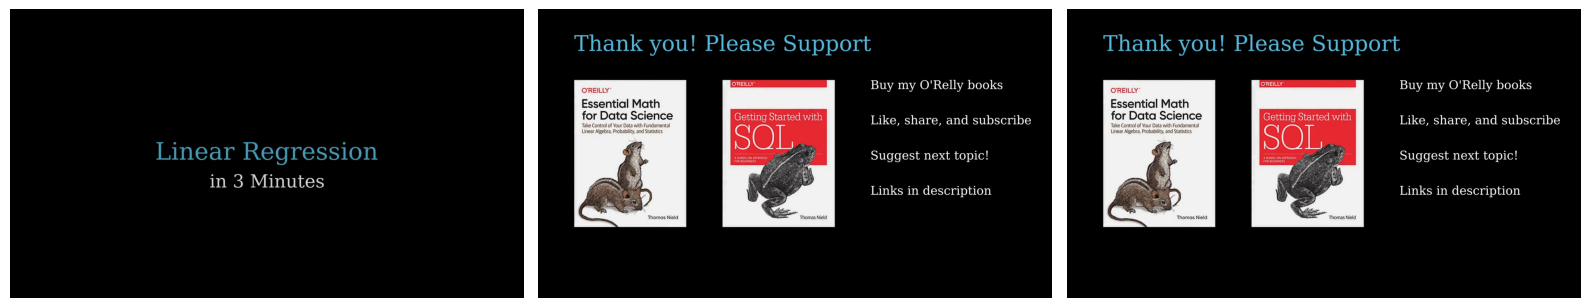

In [30]:
plot_images(img)

In [31]:
import json

metadata_str=json.dumps(metadata_vid)
query_str="can you tell me what is linear regression and equation of linear regression?"
context_str = "".join(text)
image_documents = SimpleDirectoryReader( input_files=img).load_data()

In [32]:
qa_tmpl_str=(
    "Based on the provided information, including relevant images and retrieved context from the video, \
    accurately and precisely answer the query without any additional prior knowledge.\n"

    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"

    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [33]:
from llama_index.llms.google_genai import GoogleGenAI

# Gemini multimodal model
gemini_llm = GoogleGenAI(
    model="gemini-1.5-flash",        # or "gemini-1.5-flash"
    api_key=GOOGLE_API_KEY,
    max_output_tokens=1000,
)

In [34]:
# Run completion with text + image
result = gemini_llm.complete(
    prompt=qa_tmpl_str.format(query_str=query_str, metadata_str=metadata_str,context_str=context_str),
    image_documents=image_documents,
)

print(result.text)

Linear regression is a statistical technique used to model the relationship between an output variable (dependent variable, often 'y' or f(x)) and one or more input variables (independent variables, often 'x').  It aims to fit a line (or hyperplane in higher dimensions) through data points to make predictions on unseen data, assuming a linear relationship.

The equation for simple linear regression (one input variable) is:  y = mx + b  (or f(x) = β₁x + β₀), where:

* y is the output variable
* x is the input variable
* m (or β₁) is the slope of the line, controlling its steepness.
* b (or β₀) is the y-intercept, where the line crosses the y-axis (also known as the bias in machine learning).

For multiple linear regression (multiple input variables x₁, x₂, x₃...), the equation extends to: y = β₀ + β₁x₁ + β₂x₂ + β₃x₃ + ...

